## Overall description

To create dataset for fine-tuning, I used to 2 already created fine-grained datasets:
    
1. [NERetrieve](https://arxiv.org/pdf/2310.14282):
    - Approximately **4.29 million** paragraphs from English Wikipedia.
    - A total of **500** entity types, covering a wide variety of domains such as animals, professions, locations, and cultural artifacts.
    - For mountaion entity it has `mountain of europe, mountain of asia, mountain`

2. [Few-NERD](https://arxiv.org/pdf/2105.07464v6): 
    - Contains a hierarchy of **8 coarse-grained** and **66 fine-grained** entity types
    - Sources include **188,238** sentences from Wikipedia, with **4,601,160 words** in total
    - Include general categories like Person, Location, Organization, Art, Building, Product, Event, and Miscellaneous.
    - These are more specific, such as Actor, Scholar, Airport, Hotel, Currency, and `Mountain`.
    - Conducted by 70 annotators, supported by 10 experts, ensuring high quality



## NERetrive

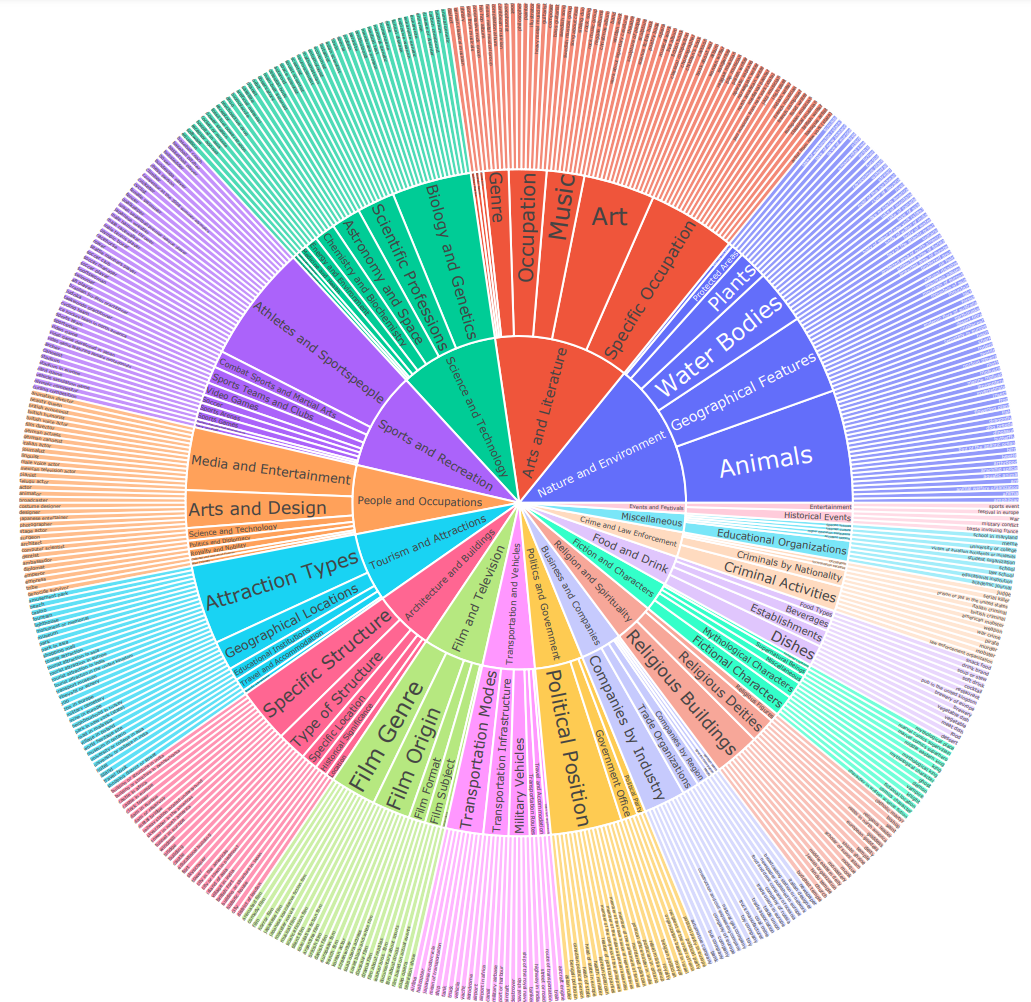
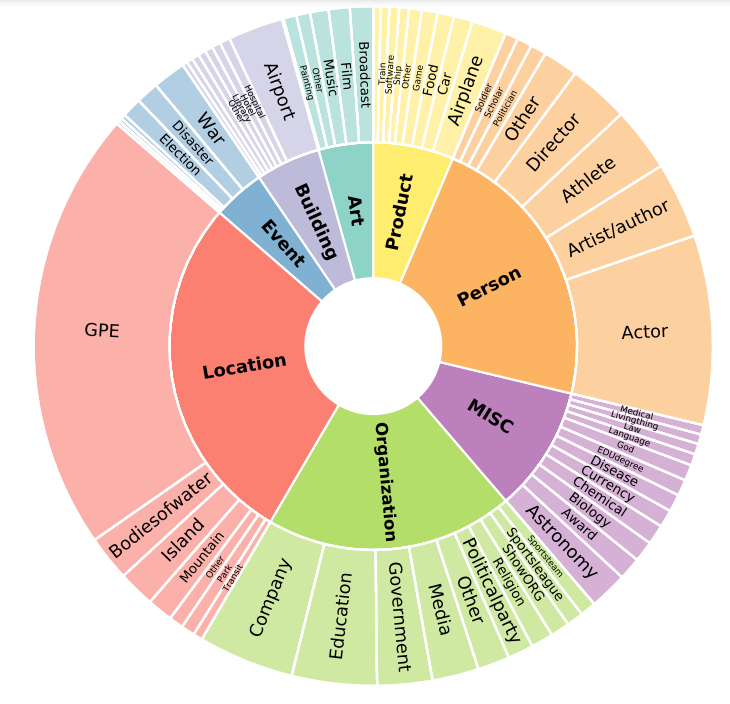

In [1]:
import json
from itertools import chain
import pandas as pd
import numpy as np

## Download data

To get NERetrieve data, you can download it from [here](https://github.com/katzurik/NERetrieve/blob/main/supervised_NER/sup_readme.md). There are train and test set. Put archives in folder datasets/archive and run the following code:

In [ ]:
import os
import zipfile

source_path = 'datasets/archive/'
destination_path = 'datasets/NERetrive/'

if not os.path.exists(source_path):
    print(f"Source path does not exist: {source_path}")
else:
    os.makedirs(destination_path, exist_ok=True)

    for file_name in os.listdir(source_path):
        if file_name.endswith('.zip'):
            zip_path = os.path.join(source_path, file_name)
            
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    print(f"Extracting {file_name} to {destination_path}...")
                    zip_ref.extractall(destination_path)
                    print(f"Extracted: {file_name}")
            except zipfile.BadZipFile:
                print(f"Bad ZIP file: {file_name}")


### Create base of dataset which constists of:
- tagged_entities
- toke_seq

In [ ]:
train_path = r'datasets\NERetrive\NERetrive_sup_train.jsonl'
test_path = r'datasets\NERetrive\NERetrive_sup_test.jsonl'

def read_jsonl(file_path):
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)

            for k in data["tagged_entities"].keys():
                if "Mountain" in k:
                    dataset.append({"tagged_entities": data["tagged_entities"], 
                                    "token_seq": data["document_token_sequence"]})
    return dataset, data

In [3]:
train_data, data = read_jsonl(train_path)
test_data, _ = read_jsonl(test_path)

print(len(train_data), len(test_data))

146834 36711


### Here we can see that original datasets consists of:
- para_index
- title 
- doc_id 
- tagged_entities 
- content
- document_token_sequence 
- page_id 
- id'

But it is reduntant to have all these columns.

In [4]:
print(data)
print(data.keys()) 
print(data.values())

{'para_index': 1, 'title': '3067 Akhmatova', 'doc_id': '3067 Akhmatova-1', 'tagged_entities': {'Soviet_scientist': {'Lyudmila_Karachkina': {'lyudmila karachkina': [[13, 14]]}}, 'Observatory': {'Crimean_Astrophysical_Observatory': {'crimean astrophysical observatory': [[17, 18, 19]]}}, 'Planet': {'Crimean_Astrophysical_Observatory': {'crimean astrophysical observatory': [[17, 18, 19]]}, '3067_Akhmatova': {'akhmatova': [[32]]}, 'Asteroid': {'asteroid': [[1]]}}, 'Scientist': {'Lyudmila_Karachkina': {'lyudmila karachkina': [[13, 14]]}, 'Anna_Akhmatova': {'anna akhmatova': [[31, 32]]}}, 'Space_scientist': {'Lyudmila_Karachkina': {'lyudmila karachkina': [[13, 14]]}}, 'Celestial_body': {'Crimean_Astrophysical_Observatory': {'crimean astrophysical observatory': [[17, 18, 19]]}, '3067_Akhmatova': {'akhmatova': [[32]]}, 'Asteroid': {'asteroid': [[1]]}}, 'Poet': {'Anna_Akhmatova': {'anna akhmatova': [[31, 32]]}}, 'Asteroid': {'Crimean_Astrophysical_Observatory': {'crimean astrophysical observator

In [5]:
print(train_data[0])

{'tagged_entities': {'Mountain_of_Asia': {'Ribu': {'ribu': [[1], [14]]}}, 'Mountain': {'Ribu': {'ribu': [[1], [14]]}}}, 'token_seq': ['A', 'ribu', 'is', 'a', 'mountain', 'that', 'reaches', 'a', 'topographic', 'prominence', 'of', 'at', 'least', '.', 'Ribu', 'is', 'an', 'Indonesian', 'word', 'meaning', 'thousand.']}


### As we filter out tagged entities, leave only Mountian entities we need to get positions of these entities in token_seq. 

In [6]:
def add_mountain_positions(data_list):
    processed_data = []
    
    for item in data_list:
        
        positions = []
        
        mountain_entities = {}
        for category, entities in item['tagged_entities'].items():
            if 'Mountain' in category:  
                mountain_entities.update(entities)
        

        for mountain_name, mountain_data in mountain_entities.items():
            for word, position_lists in mountain_data.items():
                positions.extend([pos for sublist in position_lists for pos in sublist])
        

        positions = sorted(list(set(positions))) 
        
        new_item = {
            'tagged_entities': item['tagged_entities'],
            'token_seq': item['token_seq'],
            'positions': positions
        }
        
        processed_data.append(new_item)
    
    return processed_data

In [7]:
train_data = add_mountain_positions(train_data)
test_data = add_mountain_positions(test_data)

print(train_data[0])

{'tagged_entities': {'Mountain_of_Asia': {'Ribu': {'ribu': [[1], [14]]}}, 'Mountain': {'Ribu': {'ribu': [[1], [14]]}}}, 'token_seq': ['A', 'ribu', 'is', 'a', 'mountain', 'that', 'reaches', 'a', 'topographic', 'prominence', 'of', 'at', 'least', '.', 'Ribu', 'is', 'an', 'Indonesian', 'word', 'meaning', 'thousand.'], 'positions': [1, 14]}


### Having token sequence, position of entities we can convert it into pandas for future preprocessing.
Here tagged entities are deleted as they are not needed for further processing.

In [8]:
def convert_to_dataframe(final_dataset):
    contents = []
    tokens = []
    positions = []
    
    for item in final_dataset:
        tokens.append(item['token_seq'])
        positions.append(item['positions'])
    
    df = pd.DataFrame({
        'token_seq': tokens,
        'positions': positions
    })
    
    return df

In [9]:
train_data = convert_to_dataframe(train_data)
test_data = convert_to_dataframe(test_data)

print(train_data.head())

                                           token_seq  \
0  [A, ribu, is, a, mountain, that, reaches, a, t...   
1  [A, ribu, is, a, mountain, that, reaches, a, t...   
2  [Rondane, is, a, typical, high, mountain, area...   
3  [Rondane, is, a, typical, high, mountain, area...   
4  [Mide, originally, referred, to, the, area, ar...   

                   positions  
0                    [1, 14]  
1                    [1, 14]  
2                       [25]  
3                       [25]  
4  [8, 9, 10, 148, 177, 178]  


### Additional data preprocessing include convert positions to tags.
Example: 
token_seq: ['Everest', 'is', 'the', 'highest', 'mountain', 'in', 'the', 'world'] 
positions: [0] -> 
tags: ['24', 'O', 'O', 'O', '0', 'O', 'O', 'O']


In [10]:
def positions_to_tags(positions, seq_length):

    tags = np.zeros(seq_length, dtype=int)
    tags[positions] = 24
    
    return tags.tolist()

def convert_positions_to_tags(df):

    seq_lengths = df['token_seq'].apply(len)
    
    df['tags'] = df.apply(
        lambda row: positions_to_tags(row['positions'], len(row['token_seq'])), 
        axis=1
    )
    
    return df

### Last stage of preprocessing:
- converting
- renaming
- deleting duplicates

In [11]:
train_data = convert_positions_to_tags(train_data)
test_data = convert_positions_to_tags(test_data)

train_data.rename(columns={'token_seq': 'tokens'}, inplace=True)
test_data.rename(columns={'token_seq': 'tokens'}, inplace=True)

train_data.drop(columns='positions', inplace=True)
test_data.drop(columns='positions', inplace=True)

train_data.drop_duplicates(subset='tokens', inplace=True)
test_data.drop_duplicates(subset='tokens', inplace=True)

In [12]:
train_data.to_json('NERetrive_train.json')
test_data.to_json('NERetrive_test.json')

print(train_data.head())
print(test_data.head())

                                              tokens  \
0  [A, ribu, is, a, mountain, that, reaches, a, t...   
2  [Rondane, is, a, typical, high, mountain, area...   
4  [Mide, originally, referred, to, the, area, ar...   
6  [Two, SAS, men, Brummie, Stokes, and, Bronco, ...   
8  [Amursana's, revolt, and, the, subsequent, sub...   

                                                tags  
0  [0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 24, 0, 0, 0, ...  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
                                              tokens  \
0  [Kuchl, is, situated, in, the, broad, valley, ...   
3  [The, following, year,, Semmelink, entered, th...   
6  [Florence, Nunatak, (), is, a, conspicuous, nu...   
7  [Dyhrenfurth, received, a, permit, from, the, ...   
8  [An, enormous, flight, of, steps, leads, to, t... 

## Few-NERD
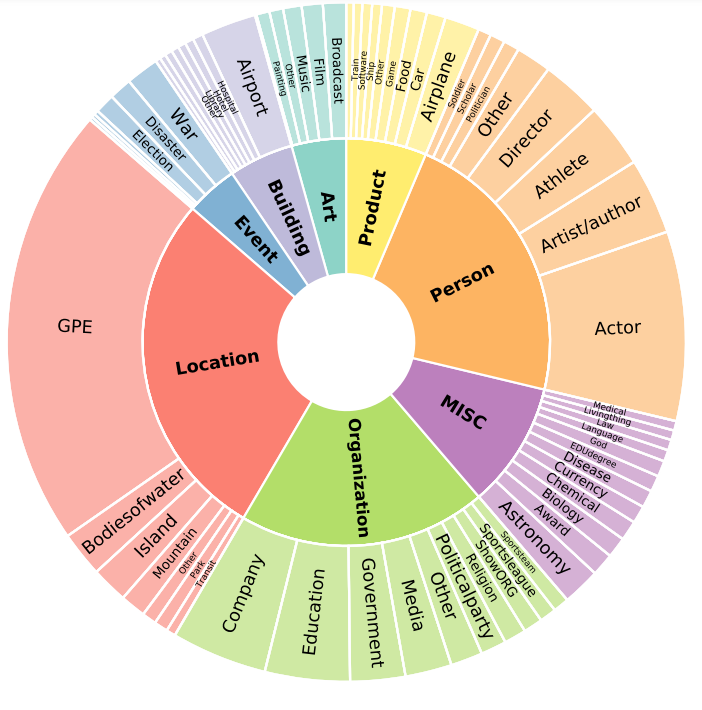

In [13]:
from datasets import load_dataset
import ast

### Few-NERD dataset is represented on Hugging Face, so preprocesing was much easier.

In [14]:
ds = load_dataset("DFKI-SLT/few-nerd", "supervised")

train_data = ds['train'].to_pandas()
test_data = ds['test'].to_pandas()
val_data = ds['validation'].to_pandas()

train_data = pd.concat([train_data, val_data], ignore_index=True)

### Dropped general ner categories and left only mountain entities.

In [15]:
train_data.drop(columns=['id', 'ner_tags'], inplace=True)
test_data.drop(columns=['id', 'ner_tags'], inplace=True)

In [16]:
def filter_by_tag(train_data, tag):
    
    mask = train_data['fine_ner_tags'].apply(lambda x: tag in x)
    filtered_data = train_data[mask].copy()
    
    return filtered_data

In [17]:
train_data = filter_by_tag(train_data, 24)
test_data = filter_by_tag(test_data, 24)

print(train_data.head())

                                                tokens  \
46   [The, Eighth, Army, began, to, attack, Italian...   
75   [Though, only, in, length, ,, The, Salamander,...   
98   [Mount, Diablo, has, inspired, many, artists, ...   
138  [K2, is, further, north, than, the, Himalayan,...   
284  [The, North, Lyell, Mine, ,, scene, of, the, 1...   

                                         fine_ner_tags  
46   [0, 32, 32, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, ...  
75              [0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0]  
98                       [24, 24, 0, 0, 0, 0, 0, 0, 0]  
138  [24, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0...  
284  [0, 11, 11, 11, 0, 0, 0, 16, 16, 16, 16, 16, 1...  


### In Few-NERD mountain entity is represented as 24

In [18]:
def filter_out_tags(train_data):
    modified_data = train_data.copy()
    
    modified_data['fine_ner_tags'] = modified_data['fine_ner_tags'].apply(
        lambda x: [tag if tag == 24 else 0 for tag in x]
    )
    
    return modified_data

In [19]:
train_data = filter_out_tags(train_data)
test_data = filter_out_tags(test_data)

print(train_data.head())
print(test_data.head())

                                                tokens  \
46   [The, Eighth, Army, began, to, attack, Italian...   
75   [Though, only, in, length, ,, The, Salamander,...   
98   [Mount, Diablo, has, inspired, many, artists, ...   
138  [K2, is, further, north, than, the, Himalayan,...   
284  [The, North, Lyell, Mine, ,, scene, of, the, 1...   

                                         fine_ner_tags  
46   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
75              [0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0]  
98                       [24, 24, 0, 0, 0, 0, 0, 0, 0]  
138  [24, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0...  
284  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
                                                tokens  \
13   [Somewhat, hidden, away, by, the, Ben, Cruacha...   
116  [The, ridge, is, situated, northeast, of, Moun...   
208  [McGillivray, Pass, (, 1867, m, or, 6215, ft, ...   
359  [The, Merced, River, meanders, through, the, l...   
444  [Montara, Stat

### Additional data preprocessing that includes:
- converting
- renaming
- deleting duplicates

In [20]:
train_data['fine_ner_tags'] = train_data['fine_ner_tags'].apply(lambda x: [int(i) for i in x])
test_data['fine_ner_tags'] = test_data['fine_ner_tags'].apply(lambda x: [int(i) for i in x])

train_data.rename(columns={'fine_ner_tags': 'tags'}, inplace=True)
test_data.rename(columns={'fine_ner_tags': 'tags'}, inplace=True)

train_data.drop_duplicates(subset='tokens', inplace=True)
test_data.drop_duplicates(subset='tokens', inplace=True)

In [ ]:
train_data.to_json('Few_NERD_train.json', orient='records')
test_data.to_json('Few_NERD_test.json', orient='records')

print(train_data.head())
print(test_data.head())

                                                tokens  \
46   [The, Eighth, Army, began, to, attack, Italian...   
75   [Though, only, in, length, ,, The, Salamander,...   
98   [Mount, Diablo, has, inspired, many, artists, ...   
138  [K2, is, further, north, than, the, Himalayan,...   
284  [The, North, Lyell, Mine, ,, scene, of, the, 1...   

                                                  tags  
46   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
75              [0, 0, 0, 0, 0, 0, 24, 24, 0, 0, 0, 0]  
98                       [24, 24, 0, 0, 0, 0, 0, 0, 0]  
138  [24, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0...  
284  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
                                                tokens  \
13   [Somewhat, hidden, away, by, the, Ben, Cruacha...   
116  [The, ridge, is, situated, northeast, of, Moun...   
208  [McGillivray, Pass, (, 1867, m, or, 6215, ft, ...   
359  [The, Merced, River, meanders, through, the, l...   
444  [Montara, Stat

## Merging

### After all data preprocessing, datasets are represented in one format:
- tokens
- tags 

In [ ]:
NERetrive_train = pd.read_json('NERetrive_train.json')
NERetrive_test = pd.read_json('NERetrive_test.json')

few_nerd_train = pd.read_json('Few_NERD_train.json')
few_nerd_test = pd.read_json('Few_NERD_test.json')

In [23]:
train_data = pd.concat([NERetrive_train, few_nerd_train], ignore_index=True)
test_data = pd.concat([NERetrive_test, few_nerd_test], ignore_index=True)

train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

### Converting tags to convenient format:
- 0 for non-entity
- 1 for mountain entity

In [24]:
train_data['tags'] = train_data['tags'].apply(lambda x: [1 if tag == 24 else 0 for tag in x])
test_data['tags'] = test_data['tags'].apply(lambda x: [1 if tag == 24 else 0 for tag in x])

### Final saving of dataset.

In [ ]:
train_data.to_json('train.json', orient='records')
test_data.to_json('test.json', orient='records')

print(train_data.head())
print(test_data.head())

                                              tokens  \
0  [On, May, 23,, 2019,, RIKEN, announced, that, ...   
1  [Lindsey, Mountain, is, a, summit, in, Iron, C...   
2  [Jesus, seems, to, recoil, from, the, impendin...   
3  [In, 2016,, Marais, participated, in, the, Two...   
4  [Initial, extrapolations, placed, Cooper's, la...   

                                                tags  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
                                              tokens  \
0  [The, temple, is, revered, in, Nalayira, Divya...   
1  [The, station's, transmitter, tower, on, Mount...   
2  [Bardon, Hill, is, also, a, 13.1, hectare, bio...   
3  [David, Sharp, (15, February, 1972, -, 15, May...   
4  [The, Queen, of, the, Field, Mice, is, a, gray... 

# Basic statistics:

In [28]:
print(len(train_data))
print(len(test_data))

88619
22110


In [29]:
import matplotlib.pyplot as plt

def distribution_plot(data, title='Token Length Distribution'):
    data['tokens'].apply(len).plot(kind='hist', bins=30)
    plt.title(title)
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()

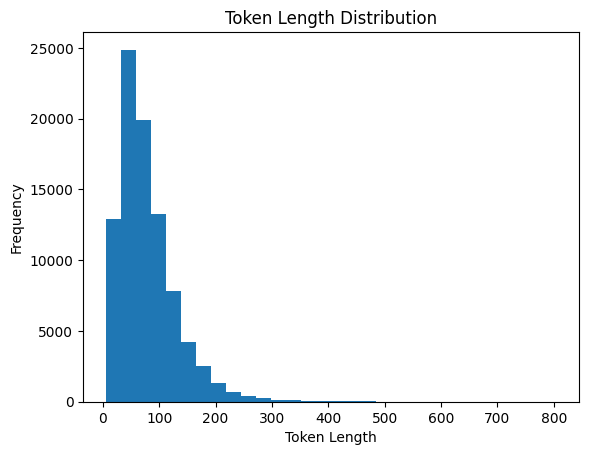

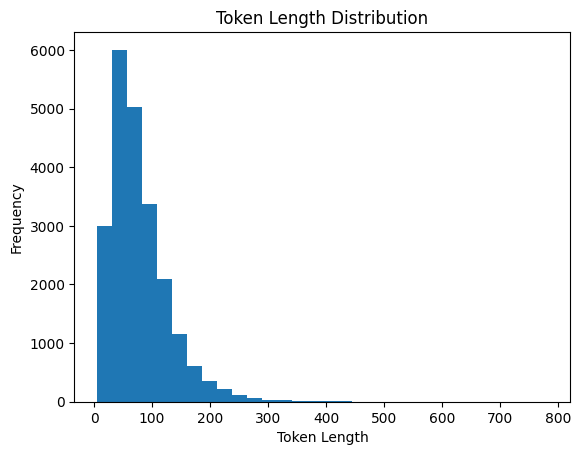

In [30]:
distribution_plot(train_data)
distribution_plot(test_data)

In [31]:
from wordcloud import WordCloud

def plot_wordcloud(data, title='Word Cloud'):
    text = ' '.join(data['tokens'].apply(' '.join))
    wordcloud = WordCloud(width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

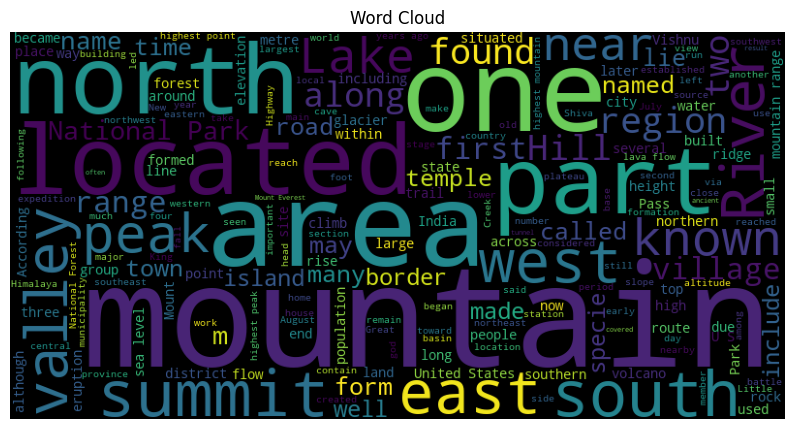

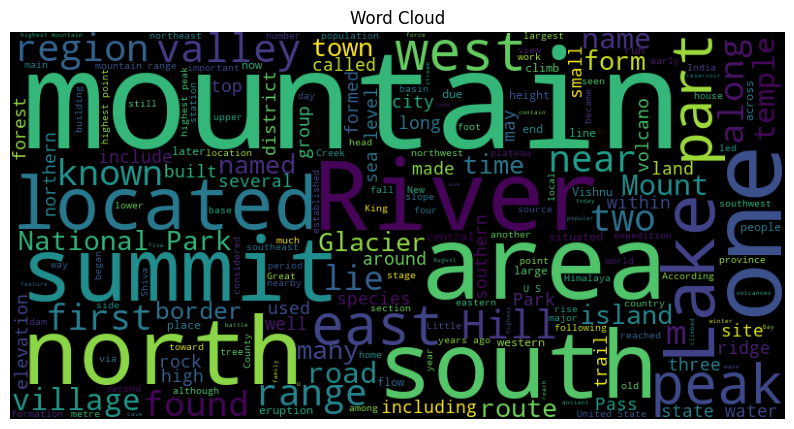

In [32]:
plot_wordcloud(train_data)
plot_wordcloud(test_data)

In [33]:
def get_vocab(data):
    vocab = set(chain(*data['tokens']))
    vocab_size = len(vocab)
    
    return vocab_size

train_vocab_size = get_vocab(train_data)
test_vocab_size = get_vocab(test_data)

print(f'Train Vocab Size: {train_vocab_size}')
print(f'Test Vocab Size: {test_vocab_size}')

Train Vocab Size: 382789
Test Vocab Size: 157918


In [34]:
def get_unique_mountain_names(data):
    mountain_names = set()

    for tokens, tags in zip(data['tokens'], data['tags']):
        for token, tag in zip(tokens, tags):
            if tag == 1:
                mountain_names.add(token)

    return len(mountain_names), mountain_names

In [36]:
unique_mountain_count, unique_mountain_names = get_unique_mountain_names(train_data)
print(f'Number of unique mountain names: {unique_mountain_count}')
print(f'Unique mountain names: {unique_mountain_names}')

Number of unique mountain names: 29537
Unique mountain names: {'Sgurr', 'Đeravica', 'Perthus', 'Mädelegabel', 'Humphreys', 'Antelao', 'Slaughter', 'Carstensz', 'south-central', 'Smart', 'Pyramid)', 'Monashee', 'Pacific', 'Waddon', 'Heidenberg', 'Schatzberg.', 'Gemini,', 'Diable,', 'Limani,', 'Kun', 'Tagh,', 'Magruder', 'Madhe', 'Pirámide,', 'Taishaku', 'Kempstone', 'Salteras', 'Diamir.1(Pamir', 'Georgia', 'Stockhorn.', 'Campbieil,', 'Leilachspitze,', 'Firehorn', 'Tofua)', 'faces', 'Ochsenhorn', 'Carmen', 'Gavrilovfjellet', 'Kaguyak,', 'Tomkins', 'Dufourspitze.', 'Strahlkogel,', 'Redentore', 'Scenery', 'Bignall', 'Beag.', 'Franzosenkopf', 'Kabru,', 'Fuji),', 'Anaconda.', 'Ross.', "Evans'", 'Borov', 'Meall', 'Raise', 'al-Sharif),', 'Snowfield', 'Sparruhorn', 'Gröss', 'Mikli', 'Rosskopf,', 'Rosennock', 'Zhuoshe', 'Gjaidstein)', 'Clachnaben.', 'Upuigma-tepui.', 'Biellesi),', 'Cachimbo.', 'Geladandong', 'Alston,', 'Wedel-Jarlsberg', 'Macaya', 'Mournes,', 'Half', 'Brunnistock.', 'Breiteberg'

# Pushing dataset to Hugging Face

In [43]:
from datasets import Dataset, DatasetDict

train_hf = Dataset.from_pandas(train_data)
test_hf = Dataset.from_pandas(test_data)

dataset = DatasetDict({
    'train': train_hf,
    'test': test_hf
})

In [ ]:
from huggingface_hub import HfApi, login

login()

def upload_to_hf(dataset_dict, dataset_name, user_name):

    repo_name = f"{user_name}/{dataset_name}"
    
    dataset_dict.push_to_hub(
        repo_name,
        private=False,  
        token=None  
    )

upload_to_hf(
    dataset_dict=dataset,
    dataset_name="mountain-ner-dataset",
    user_name="Gepe55o"
)

### Dataset usage

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Gepe55o/mountain-ner-dataset")

train_data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas() 

print(train_data.head())
print(test_data.head())